Ứng dụng phương pháp học máy trong giao dịch chứng khoán theo chỉ báo bằng ngôn ngữ lập trình Python

Cài đặt các thư viện cần thiết

In [ ]:
!pip install -U matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
!pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install pyfolio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.1 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88652 sha256=04d5412aee6770800333e3c59f4c7d895f8ad2893a5e2aebcd38dfc29c409bb7
  Stored in directory: /root/.cache/pip/wheels/71/38/bc/e53700cfd8b0ad6b539d2fbaaf060ed8a299e7622a5b86ef42
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39756 sha256=b04f52dc510f13f2ab904034de4b85c2f176f76addb355ab2d270491e70c38aa
  Stored in directory: /root/.cache/pip/wheels/0e/2e/f2/d6d2d9a1eb8fbbd9949bb5d4c00f753e3b74e5bd7ed10b1d36
Successfully built pyfolio empyrical


In [ ]:
!pip install quantstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
!pip install vnstock
from vnstock import *

In [ ]:
from datetime import datetime
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfolio as pf
import quantstats
%matplotlib notebook
from google.colab import files
from IPython.display import Image

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Bước 1: Thu thập dữ liệu cho giai đoạn 2018 - 2022

In [ ]:
#tạo danh sách các mã cổ phiếu thuộc VN30
list_i=['ACB','BCM','BID','BVH','CTG',
        'FPT','GAS','GVR', 'HDB', 'HPG',
        'MBB', 'MSN','MWG', 'PLX', 'POW',
        'SAB', 'SHB','SSB','SSI','STB',
        'TCB','TPB','VCB','VHM', 'VIB',
        'VIC','VJC', 'VNM','VPB','VRE']

#tải dữ liệu lịch sử giao dịch của các mã cổ phiếu
list_data = []
for i in list_i:
  dt=stock_historical_data(i, '2018-01-01', '2022-12-31')
  dt=dt.set_index(pd.DatetimeIndex(dt['time']))
  list_data.append(dt)

list_data

[                  time   open   high    low  close   volume ticker
 time                                                              
 2018-01-02  2018-01-02   9250   9720   9200   9700  3657426    ACB
 2018-01-03  2018-01-03   9700   9770   9500   9670  5056543    ACB
 2018-01-04  2018-01-04   9670   9720   9600   9700  6365641    ACB
 2018-01-05  2018-01-05   9750   9870   9600   9700  6453452    ACB
 2018-01-08  2018-01-08   9700  10020   9700  10020  3879771    ACB
 ...                ...    ...    ...    ...    ...      ...    ...
 2022-12-27  2022-12-27  18460  18790  18380  18420   418000    ACB
 2022-12-27  2022-12-27  18420  18880  18380  18460  2040100    ACB
 2022-12-28  2022-12-28  18460  18750  18340  18380  1826400    ACB
 2022-12-29  2022-12-29  18380  18710  18210  18380  1809100    ACB
 2022-12-30  2022-12-30  18380  18540  18210  18290  1339500    ACB
 
 [1247 rows x 7 columns],
                   time   open   high    low  close  volume ticker
 time                

Bước 2: Xây dựng thuật toán giao dịch theo chiến lược và thực thi giao dịch

Chiến lược giao dịch theo chỉ báo SMA

In [ ]:
class SMA (bt.Strategy):
  params=dict(pfast=20,pslow=50)

  def __init__(self):#xây dựng 2 đường sma
    #khai báo sma1 là ngắn hạn(pfast=20)
    self.sma1 = bt.ind.SMA(period=self.p.pfast)
    #khai báo sma2 là dài hạn(pslow=50)
    self.sma2=bt.ind.SMA(period=self.p.pslow)
    #crossover là điểm cắt, khai báo đường lấy làm chuẩn - sma1 - ngắn hạn
    self.crossover=bt.ind.CrossOver(self.sma1,self.sma2)

  def next(self):
    if not self.position:
      if self.crossover > 0: #sma20 cắt lên sma50 => giá tăng => mua
        self.buy(size = None)
    else:
      if self.crossover < 0:#sma20 cắt trên xuống sma50 => giá giảm => bán
        self.sell(size = None)

Chiến lược giao dịch theo dải Bollinger

In [ ]:
class BB(bt.Strategy):
    params = dict(bperiod=21,dev=1.25)
    def __init__(self):
      #Xác định dải Bolligner
      self.boll = bt.ind.BollingerBands(period=self.p.bperiod,
                                          devfactor=self.p.dev,
                                          plot=True, plotname='Bollinger Band',
                                          subplot=False)
      #Xác định điểm giao nhau
      #Tín hiệu mua khi giá vượt dải dưới
      self.buysig = bt.indicators.CrossOver(
      self.data0, self.boll.lines.bot, plotname='buy signal', plot=True)
      #Tín hiệu bán khi giá vượt dải trên
      self.sellsig = bt.indicators.CrossOver(
      self.data0, self.boll.lines.top,plotname='sell signal', plot=True)

    def next(self):
      if not self.position:
        if self.buysig > 0:
          self.buy(size = None)
      else:
        if self.sellsig > 0:
          self.sell(size = None)

Chiến lược giao dịch theo chỉ báo RSI

In [ ]:
class RSI(bt.Strategy):
    def __init__(self):
        # khai báo biến rsi
        self.rsi = bt.indicators.RSI(self.data, period = 14)

    def next(self):
      if not self.position:
        if self.rsi[0] < 30:
            self.buy(size = None)
      else:
        if self.rsi[0]>70:
            self.sell(size = None)

Chiến lược giao dịch theo chỉ báo MACD

In [ ]:
class MACD(bt.Strategy):
  def __init__(self):
    self.MACD = bt.ind.MACD(self.data)
    self.MACDHist= bt.ind.MACDHisto(self.data)
    self.crossover = bt.ind.CrossOver(self.MACD,0)

  def next(self):
    if not self.position:
    #Khi đường MACD cắt đường Zero từ dưới lên hay MACD chuyển dịch từ – sang +
      if self.crossover > 0:
        self.buy(size = None)
    #Khi đường MACD cắt đường Zero từ trên xuống hay MACD chuyển dịch từ + sang –
    else:
      if self.crossover < 0:
        self.sell(size = None)

Hàm thực thi giao dịch giai đoạn huấn luyện 2018 - 2022


In [ ]:
def train_trading( list_data, trading_strategy):
  after_trading=[]

  for i in list_data:
    i=i.dropna()
    data=bt.feeds.PandasData(dataname=i)

    #thực thi chiến thuật
    cerebro=bt.Cerebro() #gọi cerebro
    cerebro.addstrategy(trading_strategy)#truyền chiến thuật vào cerebro
    cerebro.adddata(data)#truyền dữ liệu

    cerebro.broker.setcash(100000000) #số tiền giao dịch ban đầu
    cerebro.broker.setcommission(commission=0.001) #phí giao dịch
    cerebro.addsizer(bt.sizers.AllInSizerInt,percents = 95) #số lượng cổ phiếu

    #thực thi chiến thuật
    cerebro.run()

    #số tiền sau khi thực hiện chiến thuật
    after_trading.append(cerebro.broker.get_value())

  return after_trading

In [ ]:
#thực hiện giao dịch trong giai đoạn 2018 - 2022
after_trading_SMA = train_trading(list_data, SMA)
after_trading_BB = train_trading(list_data, BB)
after_trading_RSI = train_trading(list_data, RSI)
after_trading_MACD = train_trading(list_data, MACD)

In [ ]:
#show kết quả giao dịch
df_result = pd.DataFrame({'ticker': list_i,
                          'SMA_after_trading':after_trading_SMA,
                          'Bollinger_after_trading': after_trading_BB,
                          'RSI_after_trading':after_trading_RSI,
                          'MACD_after_trading': after_trading_MACD}
                    )
df_result

,ticker,SMA_after_trading,Bollinger_after_trading,RSI_after_trading,MACD_after_trading
0,ACB,1.122342e+08,1.723224e+08,1.893889e+08,8.748149e+07
1,BCM,2.389265e+08,7.128599e+07,1.104724e+08,3.425291e+08
2,BID,1.096804e+08,7.725005e+07,3.419891e+08,1.757137e+08
3,BVH,6.688346e+07,5.532598e+07,1.408508e+08,6.395532e+07
4,CTG,1.127230e+08,1.028050e+08,2.151662e+08,1.426216e+08
5,FPT,2.672237e+08,1.362361e+08,1.647752e+08,2.130044e+08
6,GAS,6.885795e+07,7.114876e+07,1.697589e+08,8.964066e+07
7,GVR,2.034847e+08,1.636075e+08,6.981009e+07,1.951479e+08
8,HDB,9.570586e+07,9.315196e+07,8.257528e+07,1.079090e+08
9,HPG,2.521500e+08,3.674817e+07,7.139651e+07,2.387235e+08


Bước 3: Xây dựng 4 danh mục đầu tư tối ưu dựa trên 5 mã cổ phiếu có lợi nhuận cao nhất ở mỗi chỉ báo

Chọn 5 mã cổ phiếu sinh lợi cao nhất ở mỗi chỉ báo => 4 danh mục đầu tư tương ứng với 4 chỉ báo

In [ ]:
sorted(zip(df_result['SMA_after_trading'], df_result['ticker']), reverse=True)[:5]

[(334113454.91999996, 'VIB'),
 (272599105.99, 'SSI'),
 (267223653.84000006, 'FPT'),
 (252149968.14999998, 'HPG'),
 (238926545.33999997, 'BCM')]

In [ ]:
sorted(zip(df_result['Bollinger_after_trading'], df_result['ticker']), reverse=True)[:5]

[(172322413.7799999, 'ACB'),
 (168200068.44799992, 'TPB'),
 (163607484.04, 'GVR'),
 (136236095.46000004, 'FPT'),
 (133710062.7, 'TCB')]

In [ ]:
sorted(zip(df_result['RSI_after_trading'], df_result['ticker']), reverse=True)[:5]

[(341989061.26, 'BID'),
 (215166193.71999997, 'CTG'),
 (189388904.19999996, 'ACB'),
 (183054831.62199998, 'VRE'),
 (169758888.391, 'GAS')]

In [ ]:
sorted(zip(df_result['MACD_after_trading'], df_result['ticker']), reverse=True)[:5]

[(342529073.87, 'BCM'),
 (333003421.46000004, 'VIB'),
 (238723515.11999997, 'HPG'),
 (228716427.43600005, 'SHB'),
 (223263151.73999998, 'SSI')]

Các danh mục đầu tư tối ưu tương ứng với các chỉ báo

In [ ]:
sma_ticker = ['VIB','SSI', 'FPT', 'HPG', 'BCM' ]
bb_ticker =['ACB', 'TPB', 'GVR', 'FPT','TCB']
rsi_ticker =[ 'BID', 'CTG','ACB', 'VRE', 'GAS']
macd_ticker =['BCM','VIB','HPG','SHB','SSI']

In [ ]:
from datetime import datetime, timedelta
from scipy.optimize import minimize

In [ ]:
def download_data(ticker):
  close_df = pd.DataFrame()
  for i in ticker:
    data =  stock_historical_data(symbol= i,
                                  start_date='2018-01-01',
                                  end_date='2022-12-31')
    close_df[i]=data['close']
  return close_df

sma_port_data = download_data(sma_ticker)
bb_port_data = download_data(bb_ticker)
rsi_port_data = download_data(rsi_ticker)
macd_port_data = download_data(macd_ticker)

Hàm tính các chỉ số cần thiết để tối ưu rủi ro của danh mục

In [ ]:
def  standard_deviation(weights, cov_matrix):
  variance = weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

def expected_return(weights, log_returns):
  return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  return (expected_return(weights, log_returns)-risk_free_rate)/standard_deviation(weights,cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
  return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [ ]:
def optimal_portfolio(close_df, ticker):
  log_returns = np.log(close_df/close_df.shift(1))
  log_returns=log_returns.dropna()
  cov_matrix= log_returns.cov()*252
  risk_free_rate = 0.028
  constraints = {'type': 'eq','fun':lambda weights: np.sum(weights)-1}
  bounds = [(0.1, 0.5) for _ in range(len(ticker))]
  initial_weights = np.array([1/len(ticker)]*len(ticker))
  optimized_result = minimize(neg_sharpe_ratio, initial_weights,
                              args=(log_returns, cov_matrix, risk_free_rate,),
                              method='SLSQP', bounds=bounds,
                              constraints= constraints)
  optimal_weights = optimized_result.x
  opt_w = []
  for  weight in  optimal_weights:
    #opt_w.append('{:.3f}'.format(weight))
    opt_w.append(round(weight,2))
  return opt_w

def show_portfolio(trading_strategy,ticker,optimal_weight):

  df = pd.DataFrame({'ticker':ticker,
                     'weight':optimal_weight})
  return df



In [ ]:
sma_optimal_weights = optimal_portfolio(sma_port_data, sma_ticker)
bb_optimal_weights = optimal_portfolio(bb_port_data, bb_ticker)
rsi_optimal_weights = optimal_portfolio(rsi_port_data, rsi_ticker)
macd_optimal_weights = optimal_portfolio(macd_port_data, macd_ticker)

In [ ]:
sma = show_portfolio(SMA, sma_ticker, sma_optimal_weights)
bb = show_portfolio(BB, bb_ticker, bb_optimal_weights)
rsi = show_portfolio(RSI, rsi_ticker, rsi_optimal_weights)
macd = show_portfolio(MACD, macd_ticker, macd_optimal_weights)
print('danh mục và tỷ trọng đầu tư theo chiến thuật SMA:')
print(sma)
print('danh mục và tỷ trọng đầu tư theo chiến thuật Bollinger:')
print(bb)
print('danh mục và tỷ trọng đầu tư theo chiến thuật RSI:')
print(rsi)
print('danh mục và tỷ trọng đầu tư theo chiến thuật MACD:')
print(macd)

danh mục và tỷ trọng đầu tư theo chiến thuật SMA:
  ticker  weight
0    VIB    0.29
1    SSI    0.10
2    FPT    0.30
3    HPG    0.10
4    BCM    0.21
danh mục và tỷ trọng đầu tư theo chiến thuật Bollinger:
  ticker  weight
0    ACB     0.2
1    TPB     0.1
2    GVR     0.1
3    FPT     0.5
4    TCB     0.1
danh mục và tỷ trọng đầu tư theo chiến thuật RSI:
  ticker  weight
0    BID    0.22
1    CTG    0.10
2    ACB    0.48
3    VRE    0.10
4    GAS    0.10
danh mục và tỷ trọng đầu tư theo chiến thuật MACD:
  ticker  weight
0    BCM    0.29
1    VIB    0.41
2    HPG    0.10
3    SHB    0.10
4    SSI    0.10


In [ ]:
def expected(close_df,optimal_weights,port_return, port_risk,port_sharpe):
  log_returns = np.log(close_df/close_df.shift(1))
  log_returns=log_returns.dropna()
  cov_matrix= log_returns.cov()*252
  risk_free_rate = 0.028
  optimal_weights = np.asarray(optimal_weights, dtype='float64')

  optimal_portfolio_return = expected_return(optimal_weights,log_returns)
  optimal_portfolio_voltality = standard_deviation(optimal_weights, cov_matrix)
  optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns,
                                      cov_matrix, risk_free_rate)

  port_return.append('{:.2f}'.format(optimal_portfolio_return))
  port_risk.append('{:.2f}'.format(optimal_portfolio_voltality))
  port_sharpe.append('{:.2f}'.format(optimal_sharpe_ratio))

In [ ]:
port_return = []
port_risk = []
port_sharpe = []

expected(sma_port_data,sma_optimal_weights,port_return, port_risk,port_sharpe)
expected(bb_port_data,bb_optimal_weights,port_return, port_risk,port_sharpe)
expected(rsi_port_data,rsi_optimal_weights,port_return, port_risk,port_sharpe)
expected(macd_port_data,macd_optimal_weights,port_return, port_risk,port_sharpe)

strategy_name = ['SMA', 'Bollinger Bands','RSI', 'MACD']
portfolio_expected = pd.DataFrame({'strategy': strategy_name,
                                  'expected_return':port_return,
                                  'expected_voltality':port_risk,
                                  'expected_sharpe':port_sharpe})
portfolio_expected

,strategy,expected_return,expected_voltality,expected_sharpe
0,SMA,0.19,0.21,0.79
1,Bollinger Bands,0.18,0.17,0.86
2,RSI,0.10,0.24,0.28
3,MACD,0.19,0.24,0.68


Bước 4: Đưa các danh mục đầu tư tối ưu vào giao dịch trong năm 2023 đánh giá hiệu quả

In [ ]:
def data_2023(ticker):
  list_data_opt = []
  for i in ticker:
    dt=stock_historical_data(i, '2023-01-01', '2023-12-31')
    dt=dt.set_index(pd.DatetimeIndex(dt['time']))
    list_data_opt.append(dt)

  return list_data_opt

sma_data_2023 = data_2023(sma_ticker)
bb_data_2023 = data_2023(bb_ticker)
rsi_data_2023 = data_2023(rsi_ticker)
macd_data_2023 = data_2023(macd_ticker)

In [ ]:
def trading_in_2023(ticker,data, weights, trading_strategy):
  before_trading = []
  after_trading = []
  weights = np.asarray(weights, dtype='float64')
  for dt, w in zip(data, weights):
    #tính vốn được phân bổ
    invest_amount = w*1000000000

    dt=dt.dropna()
    data=bt.feeds.PandasData(dataname=dt)

    cerebro=bt.Cerebro() #gọi cerebro
    cerebro.addstrategy(trading_strategy)#truyền chiến thuật vào cerebro
    cerebro.adddata(data)#truyền dữ liệu

    #cho số tiền trước khi thực hiện chiến thuật
    cerebro.broker.setcash(invest_amount) #số tiền giao dịch
    cerebro.broker.setcommission(commission=0.001)#phí giao dịch
    cerebro.addsizer(bt.sizers.AllInSizerInt,percents = 95)#số lượng cổ phiếu
    # Số tiền trước khi thực hiện chiến thuật
    before_trading.append(cerebro.broker.getvalue())

    #thực thi chiến thuật
    cerebro.run()

    #số tiền sau khi thực hiện chiến thuật
    after_trading.append(cerebro.broker.getvalue())


  trading_optimal = pd.DataFrame({'ticker': ticker,
                       'before trading':before_trading,
                      'after trading': after_trading}
                    )
  return trading_optimal

In [ ]:
sma_trading_2023 = trading_in_2023(sma_ticker,sma_data_2023,sma_optimal_weights,SMA)
bb_trading_2023 = trading_in_2023(bb_ticker,bb_data_2023,bb_optimal_weights,BB)
rsi_trading_2023 = trading_in_2023(rsi_ticker,rsi_data_2023,rsi_optimal_weights,RSI)
macd_trading_2023 = trading_in_2023(macd_ticker,macd_data_2023,macd_optimal_weights,MACD)
print('Kết quả giao dịch trong năm 2023 của danh mục theo chỉ báo SMA:')
print(sma_trading_2023)
print('Kết quả giao dịch trong năm 2023 của danh mục theo chỉ báo BB:')
print(bb_trading_2023)
print('Kết quả giao dịch trong năm 2023 của danh mục theo chỉ báo RSI:')
print(rsi_trading_2023)
print('Kết quả giao dịch trong năm 2023 của danh mục theo chỉ báo MACD:')
print(macd_trading_2023)

Kết quả giao dịch trong năm 2023 của danh mục theo chỉ báo SMA:
  ticker  before trading  after trading
0    VIB     290000000.0   3.450448e+08
1    SSI     100000000.0   1.524464e+08
2    FPT     300000000.0   3.717513e+08
3    HPG     100000000.0   1.265975e+08
4    BCM     210000000.0   2.135430e+08
Kết quả giao dịch trong năm 2023 của danh mục theo chỉ báo BB:
  ticker  before trading  after trading
0    ACB     200000000.0   2.311522e+08
1    TPB     100000000.0   1.175881e+08
2    GVR     100000000.0   1.149158e+08
3    FPT     500000000.0   5.301183e+08
4    TCB     100000000.0   1.044834e+08
Kết quả giao dịch trong năm 2023 của danh mục theo chỉ báo RSI:
  ticker  before trading  after trading
0    BID     220000000.0   2.514099e+08
1    CTG     100000000.0   1.059091e+08
2    ACB     480000000.0   4.800000e+08
3    VRE     100000000.0   8.959430e+07
4    GAS     100000000.0   1.091116e+08
Kết quả giao dịch trong năm 2023 của danh mục theo chỉ báo MACD:
  ticker  before trading

In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
import xlsxwriter
writer = pd.ExcelWriter('opt_port.xlsx', mode='w', engine='xlsxwriter')
df_result.to_excel(writer, sheet_name='result 18-22')
sma.to_excel(writer,sheet_name='sma')
bb.to_excel(writer,sheet_name='bb')
rsi.to_excel(writer,sheet_name='rsi')
macd.to_excel(writer,sheet_name='macd')
portfolio_expected.to_excel(writer,sheet_name='expected')
sma_trading_2023.to_excel(writer,sheet_name='sma 2023')
bb_trading_2023.to_excel(writer,sheet_name='bb 2023')
rsi_trading_2023.to_excel(writer,sheet_name='rsi 2023')
macd_trading_2023.to_excel(writer,sheet_name='macd 2023')
writer.close()

------------------------------------------------------------------

KIỂM TRA THUẬT TOÁN GIAO DỊCH




SMA

In [ ]:
class SMA_Test (bt.Strategy):
  params=dict(pfast=20,pslow=50)

  def __init__(self):#xây dựng 2 đường sma
    #khai báo sma1 là ngắn hạn(pfast=20)
    self.sma1 = bt.ind.SMA(period=self.p.pfast)
    #khai báo sma2 là dài hạn(pslow=50)
    self.sma2=bt.ind.SMA(period=self.p.pslow)
    #crossover là điểm cắt, khai báo đường lấy làm chuẩn - sma1 - ngắn hạn
    self.crossover=bt.ind.CrossOver(self.sma1,self.sma2)
    self.order  = None
    self.price  = None
    self.comm   = None

  def log(self, txt, dt=None):
    ''' Logging function fot this strategy'''
    dt = dt or self.datas[0].datetime.date(0)
    print('%s, %s' % (dt.isoformat(), txt))

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
        # Buy/Sell order submitted/accepted to/by broker - Nothing to do
        return

    # Check if an order has been completed
    # Attention: broker could reject order if not enough cash
    if order.status in [order.Completed]:
        if order.isbuy():
            self.log(
                'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                (order.executed.price,
                 order.executed.value,
                 order.executed.comm))

            self.buyprice = order.executed.price
            self.buycomm = order.executed.comm
        else:  # Sell
            self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                     (order.executed.price,
                      order.executed.value,
                      order.executed.comm))

        #self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        self.log('Order Canceled/Margin/Rejected')

    self.order = None

  def notify_trade(self, trade):
    if not trade.isclosed:
        return

    self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
             (trade.pnl, trade.pnlcomm))

  def next(self):

    # do nothing if an order is pending
    if self.order:
        return

    # check if there is already a position
    if not self.position:
        # buy condition
        if self.crossover > 0:
            self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
            self.order = self.buy(size = None)
    else:
        # sell condition
        if self.crossover < 0:
            self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
            self.order = self.sell(Size = None)

In [ ]:
class BB_Test(bt.Strategy):
  params = dict(bperiod=21,dev=1.25)

  def __init__(self):
        #Xác định dải Bolligner
        self.boll = bt.ind.BollingerBands(period=self.p.bperiod,
                                          devfactor=self.p.dev,
                                          plot=True, plotname='Bollinger Band',
                                          subplot=False)
        #Xác định điểm giao nhau
        #Tín hiệu mua khi giá vượt dải dưới
        self.buysig = bt.indicators.CrossOver(
        self.data0, self.boll.lines.bot, plotname='buy signal', plot=True)
        #Tín hiệu bán khi giá vượt dải trên
        self.sellsig = bt.indicators.CrossOver(
        self.data0, self.boll.lines.top,plotname='sell signal', plot=True)
        self.order  = None
        self.price  = None
        self.comm   = None

  def log(self, txt, dt=None):
    ''' Logging function fot this strategy'''
    dt = dt or self.datas[0].datetime.date(0)
    print('%s, %s' % (dt.isoformat(), txt))

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
        # Buy/Sell order submitted/accepted to/by broker - Nothing to do
        return

    # Check if an order has been completed
    # Attention: broker could reject order if not enough cash
    if order.status in [order.Completed]:
        if order.isbuy():
            self.log(
                'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                (order.executed.price,
                 order.executed.value,
                 order.executed.comm))

            self.buyprice = order.executed.price
            self.buycomm = order.executed.comm
        else:  # Sell
            self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                     (order.executed.price,
                      order.executed.value,
                      order.executed.comm))

    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        self.log('Order Canceled/Margin/Rejected')

    self.order = None

  def notify_trade(self, trade):
    if not trade.isclosed:
        return

    self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
             (trade.pnl, trade.pnlcomm))

  def next(self):

    # do nothing if an order is pending
    if self.order:
        return

    if not self.position:
      if self.buysig > 0:
            self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
            self.order = self.buy(size = None)
    else:
      if self.sellsig > 0:
            self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
            self.order = self.sell(Size = None)


In [ ]:
class RSI_Test(bt.Strategy):

  def __init__(self):
        # khai báo biến rsi
        self.rsi = bt.indicators.RSI(self.data, period = 14)
        self.order  = None
        self.price  = None
        self.comm   = None

  def log(self, txt, dt=None):
    ''' Logging function fot this strategy'''
    dt = dt or self.datas[0].datetime.date(0)
    print('%s, %s' % (dt.isoformat(), txt))

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
        # Buy/Sell order submitted/accepted to/by broker - Nothing to do
        return

    # Check if an order has been completed
    # Attention: broker could reject order if not enough cash
    if order.status in [order.Completed]:
        if order.isbuy():
            self.log(
                'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                (order.executed.price,
                 order.executed.value,
                 order.executed.comm))

            self.buyprice = order.executed.price
            self.buycomm = order.executed.comm
        else:  # Sell
            self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                     (order.executed.price,
                      order.executed.value,
                      order.executed.comm))

        #self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        self.log('Order Canceled/Margin/Rejected')

    self.order = None

  def notify_trade(self, trade):
    if not trade.isclosed:
        return

    self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
             (trade.pnl, trade.pnlcomm))

  def next(self):

    # do nothing if an order is pending
    if self.order:
        return

    if not self.position:
      if self.rsi[0] < 30:
          self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
          self.order = self.buy(size = None)
    else:
      if self.rsi[0]>70:
            self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
            self.order = self.sell(Size = None)



In [ ]:
class MACD_Test(bt.Strategy):
  def __init__(self):
      self.MACD = bt.ind.MACD(self.data)
      self.MACDHist= bt.ind.MACDHisto(self.data)
      self.crossover = bt.ind.CrossOver(self.MACD,0)
      self.order  = None
      self.price  = None
      self.comm   = None

  def log(self, txt, dt=None):
    ''' Logging function fot this strategy'''
    dt = dt or self.datas[0].datetime.date(0)
    print('%s, %s' % (dt.isoformat(), txt))

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
        # Buy/Sell order submitted/accepted to/by broker - Nothing to do
        return

    # Check if an order has been completed
    # Attention: broker could reject order if not enough cash
    if order.status in [order.Completed]:
        if order.isbuy():
            self.log(
                'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                (order.executed.price,
                 order.executed.value,
                 order.executed.comm))

            self.buyprice = order.executed.price
            self.buycomm = order.executed.comm
        else:  # Sell
            self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                     (order.executed.price,
                      order.executed.value,
                      order.executed.comm))

        #self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        self.log('Order Canceled/Margin/Rejected')

    self.order = None

  def notify_trade(self, trade):
    if not trade.isclosed:
        return

    self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
             (trade.pnl, trade.pnlcomm))

  def next(self):

    # do nothing if an order is pending
      if self.order:
        return
      if not self.position:
        #Khi đường MACD cắt đường Zero từ dưới lên hay MACD chuyển dịch từ – sang +
        if self.crossover > 0:
            self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
            self.order = self.buy(size = None)
      else:
        if self.crossover < 0:
            self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
            self.order = self.sell(Size = None)

In [ ]:
def test_trading (ticker, strategy, money):
  dt=stock_historical_data(ticker, '2018-01-01', '2022-12-31')
  dt=dt.set_index(pd.DatetimeIndex(dt['time']))
  data=bt.feeds.PandasData(dataname=dt)

#thực thi chiến thuật
  cerebro=bt.Cerebro() #gọi cerebro
  cerebro.addstrategy(strategy)#truyền chiến thuật vào cerebro
  cerebro.adddata(data)#truyền dữ liệu

#cho số tiền trước khi thực hiện chiến thuật
  cerebro.broker.setcash(money) #số tiền giao dịch
  cerebro.broker.setcommission(commission=0.001)
  cerebro.addsizer(bt.sizers.AllInSizerInt,percents = 95)

  print('Start Portfolio Value: %.2f' % cerebro.broker.get_value())

  cerebro.run() #thực thi chiến thuật

  #số tiền sau khi thực hiện chiến thuật
  print('Final Portfolio Value: %.2f' % cerebro.broker.get_value())

  cerebro.plot()  # vẽ cerebro

  plt.savefig('plot_{}'.format(strategy) + '.png')
  Image('plot_{}'.format(strategy) + '.png')

In [ ]:
test_trading('BCM', SMA_Test, 100000000)

Start Portfolio Value: 100000000.00
2018-09-27, BUY CREATED --- Price: 18570.00
2018-09-28, BUY EXECUTED, Price: 18480.00, Cost: 94525200.00, Comm 94525.20
2018-11-28, SELL CREATED --- Price: 19500.00
2018-11-29, SELL EXECUTED, Price: 18850.00, Cost: 94525200.00, Comm 96417.75
2018-11-29, OPERATION PROFIT, GROSS 1892550.00, NET 1701607.05
2018-12-03, BUY CREATED --- Price: 20610.00
2018-12-04, BUY EXECUTED, Price: 20430.00, Cost: 95755410.00, Comm 95755.41
2019-02-01, SELL CREATED --- Price: 20710.00
2019-02-11, SELL EXECUTED, Price: 21720.00, Cost: 95755410.00, Comm 101801.64
2019-02-11, OPERATION PROFIT, GROSS 6046230.00, NET 5848672.95
2019-02-26, BUY CREATED --- Price: 23210.00
2019-02-27, BUY EXECUTED, Price: 24240.00, Cost: 106704480.00, Comm 106704.48
2019-04-25, SELL CREATED --- Price: 22290.00
2019-04-26, SELL EXECUTED, Price: 22190.00, Cost: 106704480.00, Comm 97680.38
2019-04-26, OPERATION PROFIT, GROSS -9024100.00, NET -9228484.86
2019-06-14, BUY CREATED --- Price: 23300.00

<IPython.core.display.Javascript object>

In [ ]:
test_trading('BCM', BB_Test, 100000000)

Start Portfolio Value: 100000000.00
2018-05-08, BUY CREATED --- Price: 23120.00
2018-05-09, BUY EXECUTED, Price: 22660.00, Cost: 93087280.00, Comm 93087.28
2018-07-31, SELL CREATED --- Price: 16440.00
2018-08-01, SELL EXECUTED, Price: 15700.00, Cost: 93087280.00, Comm 64495.60
2018-08-01, OPERATION PROFIT, GROSS -28591680.00, NET -28749262.88
2018-09-04, BUY CREATED --- Price: 14020.00
2018-09-05, BUY EXECUTED, Price: 13830.00, Cost: 66757410.00, Comm 66757.41
2018-09-20, SELL CREATED --- Price: 14580.00
2018-09-21, SELL EXECUTED, Price: 13930.00, Cost: 66757410.00, Comm 67240.11
2018-09-21, OPERATION PROFIT, GROSS 482700.00, NET 348702.48
2018-11-07, BUY CREATED --- Price: 18290.00
2018-11-08, BUY EXECUTED, Price: 18390.00, Cost: 68374020.00, Comm 68374.02
2018-11-28, SELL CREATED --- Price: 19500.00
2018-11-29, SELL EXECUTED, Price: 18850.00, Cost: 68374020.00, Comm 70084.30
2018-11-29, OPERATION PROFIT, GROSS 1710280.00, NET 1571821.68
2019-01-04, BUY CREATED --- Price: 21080.00
201

In [ ]:
test_trading('BCM', RSI_Test, 100000000)

Start Portfolio Value: 100000000.00
2018-03-13, BUY CREATED --- Price: 18390.00
2018-03-14, BUY EXECUTED, Price: 17740.00, Cost: 91627100.00, Comm 91627.10
2018-09-24, SELL CREATED --- Price: 16900.00
2018-09-25, SELL EXECUTED, Price: 16900.00, Cost: 91627100.00, Comm 87288.50
2018-09-25, OPERATION PROFIT, GROSS -4338600.00, NET -4517515.60
2019-11-14, BUY CREATED --- Price: 27210.00
2019-11-15, BUY EXECUTED, Price: 26830.00, Cost: 89424390.00, Comm 89424.39
2020-05-26, SELL CREATED --- Price: 25690.00
2020-05-27, SELL EXECUTED, Price: 26060.00, Cost: 89424390.00, Comm 86857.98
2020-05-27, OPERATION PROFIT, GROSS -2566410.00, NET -2742692.37
2020-11-19, BUY CREATED --- Price: 36340.00
2020-11-20, BUY EXECUTED, Price: 36340.00, Cost: 88088160.00, Comm 88088.16
2020-11-27, SELL CREATED --- Price: 41250.00
2020-11-30, SELL EXECUTED, Price: 41340.00, Cost: 88088160.00, Comm 100208.16
2020-11-30, OPERATION PROFIT, GROSS 12120000.00, NET 11931703.68
2021-04-15, BUY CREATED --- Price: 50480.0

In [ ]:
test_trading('BCM', MACD_Test, 100000000)

Start Portfolio Value: 100000000.00
2018-09-21, BUY CREATED --- Price: 15970.00
2018-09-24, BUY EXECUTED, Price: 16440.00, Cost: 97785120.00, Comm 97785.12
2019-01-21, SELL CREATED --- Price: 20430.00
2019-01-22, SELL EXECUTED, Price: 21170.00, Cost: 97785120.00, Comm 125919.16
2019-01-22, OPERATION PROFIT, GROSS 28134040.00, NET 27910335.72
2019-02-11, BUY CREATED --- Price: 21720.00
2019-02-12, BUY EXECUTED, Price: 21820.00, Cost: 122061080.00, Comm 122061.08
2019-04-11, SELL CREATED --- Price: 22010.00
2019-04-12, SELL EXECUTED, Price: 22840.00, Cost: 122061080.00, Comm 127766.96
2019-04-12, OPERATION PROFIT, GROSS 5705880.00, NET 5456051.96
2019-06-11, BUY CREATED --- Price: 24330.00
2019-06-12, BUY EXECUTED, Price: 24240.00, Cost: 126217680.00, Comm 126217.68
2019-09-17, SELL CREATED --- Price: 29500.00
2019-09-18, SELL EXECUTED, Price: 29500.00, Cost: 126217680.00, Comm 153606.50
2019-09-18, OPERATION PROFIT, GROSS 27388820.00, NET 27108995.82
2019-09-24, BUY CREATED --- Price: 3

In [ ]:
test_trading('ACB', RSI_Test, 480000000)

Start Portfolio Value: 480000000.00
2018-04-26, BUY CREATED --- Price: 11160.00
2018-04-27, BUY EXECUTED, Price: 10070.00, Cost: 411460200.00, Comm 411460.20
2019-07-19, SELL CREATED --- Price: 9870.00
2019-07-22, SELL EXECUTED, Price: 10840.00, Cost: 411460200.00, Comm 442922.40
2019-07-22, OPERATION PROFIT, GROSS 31462200.00, NET 30607817.40
2019-08-06, BUY CREATED --- Price: 8920.00
2019-08-07, BUY EXECUTED, Price: 8960.00, Cost: 487244800.00, Comm 487244.80
2019-10-14, SELL CREATED --- Price: 10070.00
2019-10-15, SELL EXECUTED, Price: 10070.00, Cost: 487244800.00, Comm 547606.60
2019-10-15, OPERATION PROFIT, GROSS 60361800.00, NET 59326948.60
2020-03-23, BUY CREATED --- Price: 7940.00
2020-03-24, BUY EXECUTED, Price: 7850.00, Cost: 535299350.00, Comm 535299.35
2020-05-26, SELL CREATED --- Price: 9580.00
2020-05-27, SELL EXECUTED, Price: 9660.00, Cost: 535299350.00, Comm 658725.06
2020-05-27, OPERATION PROFIT, GROSS 123425710.00, NET 122231685.59
2021-01-28, BUY CREATED --- Price: 1

In [ ]:
def test_2023(ticker, strategy, money):
  dt=stock_historical_data(ticker, '2023-01-01', '2023-12-31')
  dt=dt.set_index(pd.DatetimeIndex(dt['time']))
  data=bt.feeds.PandasData(dataname=dt)

#thực thi chiến thuật
  cerebro=bt.Cerebro() #gọi cerebro
  cerebro.addstrategy(strategy)#truyền chiến thuật vào cerebro
  cerebro.adddata(data)#truyền dữ liệu

#cho số tiền trước khi thực hiện chiến thuật
  cerebro.broker.setcash(money) #số tiền giao dịch
  cerebro.broker.setcommission(commission=0.001)
  cerebro.addsizer(bt.sizers.AllInSizerInt,percents = 95)

  print('Start Portfolio Value: %.2f' % cerebro.broker.get_value())

  cerebro.run() #thực thi chiến thuật

  #số tiền sau khi thực hiện chiến thuật
  print('Final Portfolio Value: %.2f' % cerebro.broker.get_value())

  cerebro.plot()  # vẽ cerebro

  plt.savefig('plot_{}'.format(strategy) + '.png')
  Image('plot_{}'.format(strategy) + '.png')

In [ ]:
test_2023('FPT', SMA_Test, 100000000)
test_2023('FPT', BB_Test, 100000000)
test_2023('FPT', RSI_Test, 100000000)
test_2023('FPT', MACD_Test, 100000000)

Start Portfolio Value: 100000000.00
2023-05-18, BUY CREATED --- Price: 70440.00
2023-05-19, BUY EXECUTED, Price: 70520.00, Cost: 95060960.00, Comm 95060.96
2023-10-26, SELL CREATED --- Price: 86800.00
2023-10-27, SELL EXECUTED, Price: 87500.00, Cost: 95060960.00, Comm 117950.00
2023-10-27, OPERATION PROFIT, GROSS 22889040.00, NET 22676029.04
2023-12-05, BUY CREATED --- Price: 94800.00
2023-12-06, BUY EXECUTED, Price: 95000.00, Cost: 116755000.00, Comm 116755.00
Final Portfolio Value: 123911174.04
Start Portfolio Value: 100000000.00
2023-03-08, BUY CREATED --- Price: 67550.00
2023-03-09, BUY EXECUTED, Price: 67550.00, Cost: 94975300.00, Comm 94975.30
2023-04-03, SELL CREATED --- Price: 68400.00
2023-04-04, SELL EXECUTED, Price: 68740.00, Cost: 94975300.00, Comm 96648.44
2023-04-04, OPERATION PROFIT, GROSS 1673140.00, NET 1481516.26
2023-05-08, BUY CREATED --- Price: 66780.00
2023-05-09, BUY EXECUTED, Price: 66780.00, Cost: 96363540.00, Comm 96363.54
2023-05-12, SELL CREATED --- Price: 6

In [ ]:
test_2023('VRE', RSI_Test, 100000000)

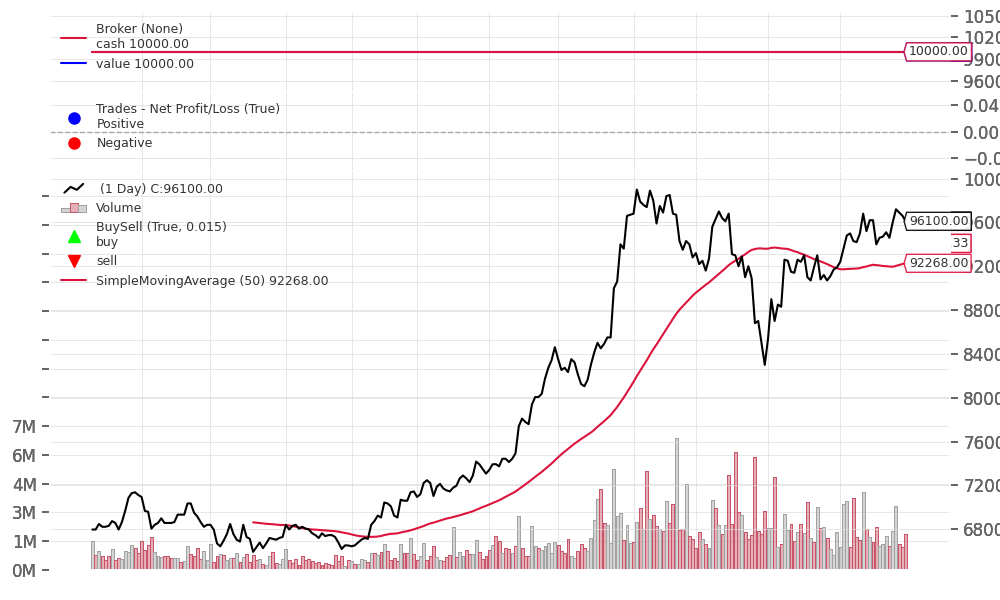

In [ ]:
class sma(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data,period = 50)

dt=stock_historical_data('FPT', '2023-01-01', '2023-12-31')
dt=dt.set_index(pd.DatetimeIndex(dt['time']))
data=bt.feeds.PandasData(dataname=dt)

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(sma)
cerebro.run()
cerebro.plot()
plt.savefig('plot_SMA.png')
Image('plot_SMA.png')

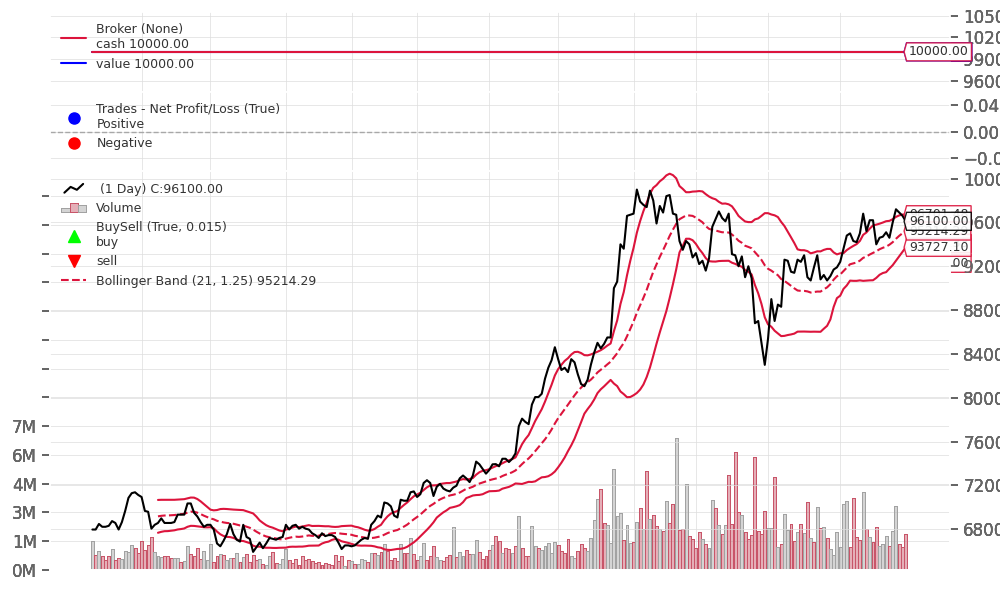

In [ ]:
class bb(bt.Strategy):
  params = dict(bperiod=21,dev=1.25)

  def __init__(self):
        #Xác định dải Bolligner
        self.boll = bt.ind.BollingerBands(period=self.p.bperiod,
                                          devfactor=self.p.dev,
                                          plot=True, plotname='Bollinger Band',
                                          subplot=False)

dt=stock_historical_data('FPT', '2023-01-01', '2023-12-31')
dt=dt.set_index(pd.DatetimeIndex(dt['time']))
data=bt.feeds.PandasData(dataname=dt)

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(bb)
cerebro.run()
cerebro.plot()
plt.savefig('plot_BB.png')
Image('plot_BB.png')

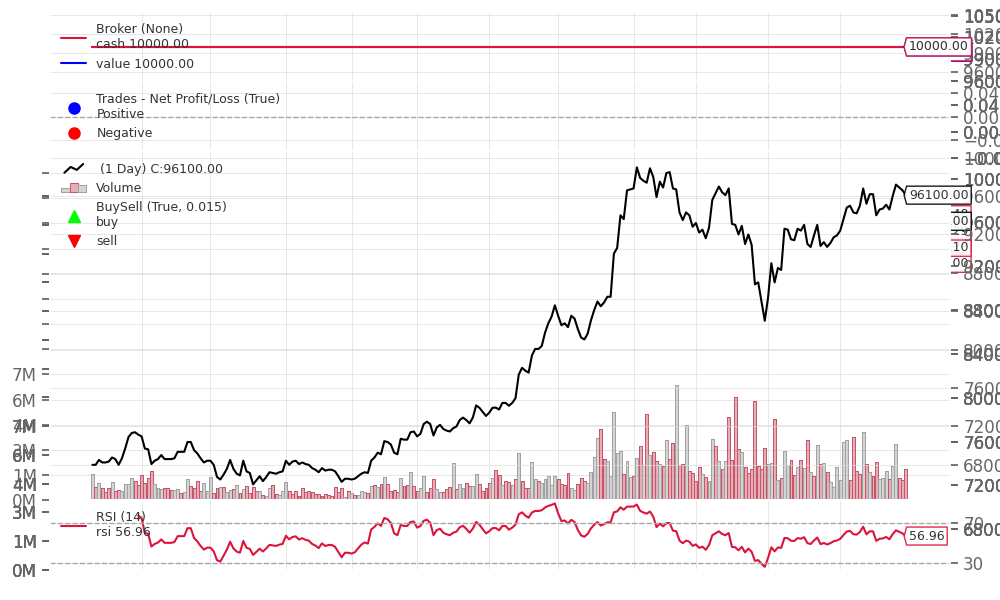

In [ ]:
class rsi(bt.Strategy):
  def __init__(self):
        # khai báo biến rsi
        self.rsi = bt.indicators.RSI(self.data, period = 14)

dt=stock_historical_data('FPT', '2023-01-01', '2023-12-31')
dt=dt.set_index(pd.DatetimeIndex(dt['time']))
data=bt.feeds.PandasData(dataname=dt)

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(rsi)
cerebro.run()
cerebro.plot()
plt.savefig('plot_RSI.png')
Image('plot_RSI.png')

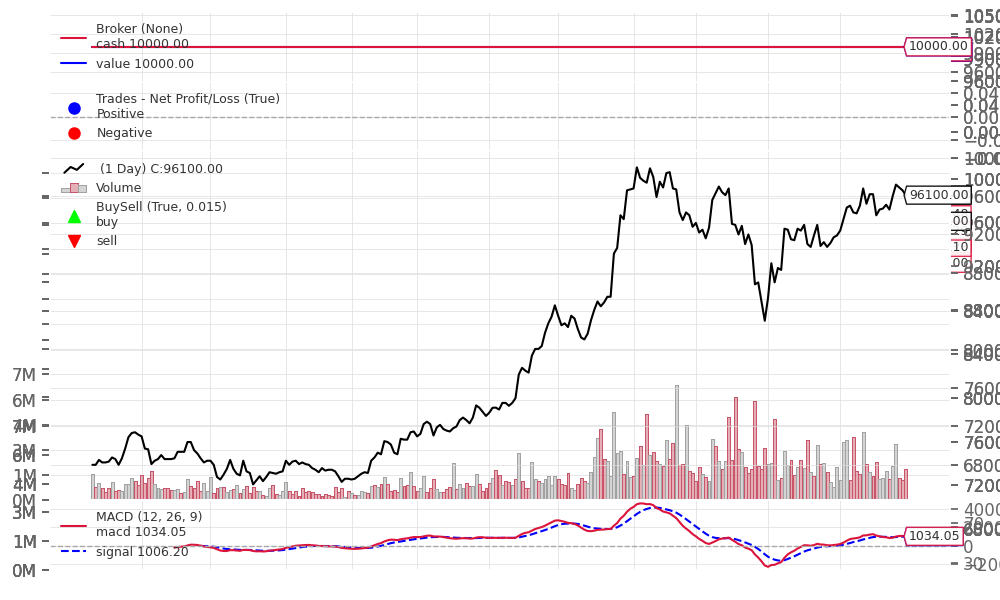

In [ ]:
class macd(bt.Strategy):
  def __init__(self):
      self.MACD = bt.ind.MACD(self.data)

dt=stock_historical_data('FPT', '2023-01-01', '2023-12-31')
dt=dt.set_index(pd.DatetimeIndex(dt['time']))
data=bt.feeds.PandasData(dataname=dt)

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(macd)
cerebro.run()
cerebro.plot()
plt.savefig('plot_macd.png')
Image('plot_macd.png')